# 1. Set up

In [1]:
# !pip install neo4j
# !pip install torch
# !pip install torch_geometric

# 2. Import necessary libraries

In [2]:
from neo4j import GraphDatabase

In [3]:
import torch
from torch_geometric.data import Data

# 3. Define global variables

In [4]:
URI = "bolt://localhost:7687"
USERNAME = "neo4j"
PASSWORD = "password"

# 4. Functions

In [5]:
def run_query(query, parameters=None):
    """
    Function used to run a Cypher query against a neo4j graph database.

    Parameters:
        - query: The query itself.
        - parameters: 
    """
    with driver.session() as session:
        result = session.run(query, parameters)
        return [record for record in result]

# 5. Code

## 5.1. Data extraction

We need to extract the data in order to train our dummy GNN model

In [6]:
driver = GraphDatabase.driver(URI, auth=(USERNAME, PASSWORD))

In [7]:
query = "MATCH (n) RETURN count(n) AS node_count"
result = run_query(query)

print(f"Número de nodos en la base de datos: {result[0]['node_count']}")

Número de nodos en la base de datos: 38


In [8]:
result

[<Record node_count=38>]

Vamos a parar la parte de la extracción y pegamos abajo el código que nos proporciona claude para crear el esqueleto del modelado de la red neuronal de grafos

**Librerías que necesitamos -> torch, torch_geometric, sklearn, numpy, pandas, seaborn**

In [9]:
import os

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import train_test_split_edges
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
import warnings
from config import *
warnings.filterwarnings('ignore')

## 5.2. Data processing

We perform the data processing:

In [10]:
class FraudGraphDataProcessor:
    """
    Procesador de datos para crear grafos de detección de fraudes
    """
    
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.node_features = None
        self.edge_index = None
        self.labels = None
        
    def load_neo4j_data(self, neo4j_connection) -> Dict:
        """
        Carga datos desde Neo4j (adaptable a tu conexión)
        """
        # Consulta para obtener nodos CONTADOR con sus características
        contador_query = """
        MATCH (c:CONTADOR)
        OPTIONAL MATCH (c)-[:INVOLUCRADO_EN_FRAUDE]->(ef:EXPEDIENTE_FRAUDE)
        OPTIONAL MATCH (c)-[:MIDE_CONSUMO_DE]->(s:SUMINISTRO)
        OPTIONAL MATCH (c)-[:INSTALADO_EN]->(u:UBICACION)
        OPTIONAL MATCH (c)-[:GENERA_MEDICION]->(m:MEDICION)
        RETURN 
            c.nis_rad as node_id,
            c.marca_contador as marca,
            c.modelo_contador as modelo,
            c.estado_tg as estado_tg,
            c.telegest_activo as telegest_activo,
            c.potencia_maxima as potencia_maxima,
            c.fases_contador as fases,
            s.potencia_contratada as potencia_contratada,
            s.estado_contrato as estado_contrato,
            u.coordenada_x as coord_x,
            u.coordenada_y as coord_y,
            avg(m.energia_activa) as consumo_promedio,
            stdev(m.energia_activa) as consumo_variabilidad,
            count(m) as num_mediciones,
            COALESCE(ef.tipo_anomalia, 'NORMAL')  as label,
            ef.clasificacion_fraude as tipo_fraude,
            ef.valoracion_total as impacto_economico
        """
        
        # Consulta para obtener relaciones
        edges_query = """
        MATCH (c1:CONTADOR)-[:INSTALADO_EN]->(u:UBICACION)<-[:INSTALADO_EN]-(c2:CONTADOR)
        WHERE c1 <> c2
        AND point.distance(
            point({x: u.coordenada_x, y: u.coordenada_y}),
            point({x: u.coordenada_x, y: u.coordenada_y})
        ) < 5000
        RETURN c1.nis_rad as source, c2.nis_rad as target, 'CERCANO' as relation_type
        
        UNION
        
        MATCH (c1:CONTADOR)-[:MIDE_CONSUMO_DE]->(s:SUMINISTRO)-[:CONTRATADO_CON]->(com:COMERCIALIZADORA)
              <-[:CONTRATADO_CON]-(s2:SUMINISTRO)<-[:MIDE_CONSUMO_DE]-(c2:CONTADOR)
        WHERE c1 <> c2
        RETURN c1.nis_rad as source, c2.nis_rad as target, 'MISMA_COMERCIALIZADORA' as relation_type
        """
        
        # Simulación de datos. Más adelante lo modificaremos con nuestra conexión real
        return self._simulate_data()
    
    def _simulate_data(self) -> Dict:
        """
        Simula datos basados en el esquema de Neo4j
        """
        np.random.seed(RANDOM_SEED)
        
        # Crear nodos de contadores, en este caso crearemos 10500:
        n_nodes = 10000
        n_fraud = 500  # Setearemos un 5% fraudes
        
        # Características de nodos
        node_data = {
            'node_id': [f"NIS_{i:06d}" for i in range(n_nodes)],
            'marca': np.random.choice(['MARCA_A', 'MARCA_B', 'MARCA_C'], n_nodes),
            'modelo': np.random.choice(['MOD_1', 'MOD_2', 'MOD_3'], n_nodes),
            'estado_tg': np.random.choice(['INTEGRADO', 'NO_INTEGRADO'], n_nodes, p=[0.8, 0.2]),
            'telegest_activo': np.random.choice([True, False], n_nodes, p=[0.9, 0.1]),
            'potencia_maxima': np.random.normal(5000, 2000, n_nodes),
            'potencia_contratada': np.random.normal(3000, 1500, n_nodes),
            'coord_x': np.random.uniform(400000, 600000, n_nodes),
            'coord_y': np.random.uniform(4400000, 4800000, n_nodes),
            'consumo_promedio': np.random.exponential(50, n_nodes),
            'consumo_variabilidad': np.random.exponential(20, n_nodes),
            'num_mediciones': np.random.poisson(100, n_nodes),
        }
        
        # Crear etiquetas (la mayoría normal, algunos fraudes)
        labels = ['NORMAL'] * n_nodes
        fraud_indices = np.random.choice(n_nodes, n_fraud, replace=False)
        
        for i in fraud_indices:
            labels[i] = 'FRAUDE'
            # Hacer que los fraudes tengan patrones diferentes
            if labels[i] == 'FRAUDE':
                node_data['consumo_promedio'][i] *= 0.3  # Consumo muy bajo
                node_data['consumo_variabilidad'][i] *= 0.5  # Menor variabilidad
            
        node_data['label'] = labels
        
        # Crear las relaciones entre nodos
        edges = []
        
        # Bordes por proximidad geográfica
        for i in range(n_nodes):
            for j in range(i+1, min(i+20, n_nodes)):  # Limitar para eficiencia
                dist = np.sqrt((node_data['coord_x'][i] - node_data['coord_x'][j])**2 + 
                              (node_data['coord_y'][i] - node_data['coord_y'][j])**2)
                if dist < 5000:  # 5km
                    edges.append([i, j])
                    edges.append([j, i])  # Borde bidireccional
        
        # Bordes por similaridad técnica
        for i in range(n_nodes):
            for j in range(i+1, n_nodes):
                if (node_data['marca'][i] == node_data['marca'][j] and 
                    node_data['modelo'][i] == node_data['modelo'][j] and
                    np.random.random() < 0.1):  # 10% de probabilidad
                    edges.append([i, j])
                    edges.append([j, i])
        
        return {
            'nodes': pd.DataFrame(node_data),
            'edges': np.array(edges) if edges else np.array([]).reshape(0, 2)
        }
    
    def create_graph_data(self, data: Dict) -> Data:
        """
        Convierte datos en formato PyTorch Geometric
        """
        
        nodes_df = data['nodes']
        edges = data['edges']
        
        # Mapear node_ids a índices
        node_to_idx = {node_id: idx for idx, node_id in enumerate(nodes_df['node_id'])}
        


        # Preparar características de nodos
        feature_columns = [
            'potencia_maxima', 'potencia_contratada', 'coord_x', 'coord_y',
            'consumo_promedio', 'consumo_variabilidad', 'num_mediciones'
        ]
        
        # Codificar características categóricas
        marca_encoded = pd.get_dummies(nodes_df['marca'], prefix='marca')
        modelo_encoded = pd.get_dummies(nodes_df['modelo'], prefix='modelo')
        estado_tg_encoded = pd.get_dummies(nodes_df['estado_tg'], prefix='estado_tg')
        
        # Características binarias
        telegest_feature = nodes_df['telegest_activo'].astype(int)
        
        # Combinar todas las características
        numeric_features = self.scaler.fit_transform(nodes_df[feature_columns])
        
        node_features = np.concatenate([
            numeric_features,
            marca_encoded.values,
            modelo_encoded.values,
            estado_tg_encoded.values,
            telegest_feature.values.reshape(-1, 1)
        ], axis=1)
        
        # Preparar etiquetas
        labels = [FRAUD_CLASSES.get(label, 0) for label in nodes_df['label']]
        
        # Crear tensores
        x = torch.tensor(node_features, dtype=torch.float)
        x = torch.nan_to_num(x, nan=0.0)
        y = torch.tensor(labels, dtype=torch.long)
        y = torch.nan_to_num(y, nan=0.0)
        print(f"x : {x}, y: {y}")
        
        # # Crear edge_index
        # if len(edges) > 0:
        #     edge_index = torch.tensor(edges.T, dtype=torch.long)
        # else:
        #     edge_index = torch.empty((2, 0), dtype=torch.long)
        
        # Si edges contiene node_ids (strings), mapearlos a índices:
        if len(edges) > 0:
            edges_mapped = []
            for edge in edges:
                # Mapear node_ids a índices si son strings
                # source_idx = node_to_idx.get(edge[0], edge[0]) if isinstance(edge[0], str) else edge[0]
                # target_idx = node_to_idx.get(edge[1], edge[1]) if isinstance(edge[1], str) else edge[1]
                # edges_mapped.append([source_idx, target_idx])
                try:
                    # Intentar convertir directamente a entero
                    source_idx = int(edge[0])
                    target_idx = int(edge[1])
                except (ValueError, TypeError):
                    # Si falla, usar el mapeo
                    source_idx = node_to_idx.get(str(edge[0]), 0)  # Default a 0 si no encuentra
                    target_idx = node_to_idx.get(str(edge[1]), 0)

                edges_mapped.append([source_idx, target_idx])

            edge_index = torch.tensor(np.array(edges_mapped, dtype=np.int64).T, dtype=torch.long)
        else:
            edge_index = torch.empty((2, 0), dtype=torch.int64)

        # Crear objeto Data
        graph_data = Data(x=x, edge_index=edge_index, y=y)
        
        # Guardar información para uso posterior
        self.node_features = node_features
        self.labels = labels
        self.feature_names = (feature_columns + 
                             list(marca_encoded.columns) + 
                             list(modelo_encoded.columns) + 
                             list(estado_tg_encoded.columns) + 
                             ['telegest_activo'])
        
        return graph_data

## 5.3. Modelo GNN

Vamos a construir la arquitectura, el esqueleto de la red neuronal GNN que será o bien una GCN o bien una GAT

In [11]:
# ==========================================
# 3. MODELO GNN
# ==========================================

# Construimos la clase FraudGNN compuesta por dos funciones, el __init__ y forward. 
class FraudGNN(nn.Module):
    """
    Construcción de la arquitectura del modelo GNN para detección de fraudes
    """
    # Consideramos que hay 3 etiquetas: Normal, irregularidad y fraude:
    def __init__(self, input_dim: int, hidden_dim: int = HIDDEN_DIM, 
                 num_classes: int = 2, num_layers: int = NUM_LAYERS,
                 dropout: float = DROPOUT, model_type: str = 'GCN'):
        """
        El constructor de la arquitectura en la que se define la arquitectura, qué capas tendrá y cómo estarán conectadas.

        Parámetros:
            - input_dim: Número de características (por contador, en este caso)
            - hidden_dim: Tamaño de las capas ocultas (ej: 64 neuronas)
            - num_classes: Número de clases a predecir (en este caso, 3)
            - num_layers: Número de capas del modelo.
            - dropout: Probabilidad de "apagar" neuronas, evitamos overfitting.
            - model_type: Tipo de GNN, o bien una GCN o bien una GAT.
        """
        super(FraudGNN, self).__init__()
        
        self.model_type = model_type
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Creamos dos listas, por un lado una guardará las capas de convolución y la otra las capas de normalización.
        # Recuérdese que en una convolución en grafos, lo que hacemos es mirar nodos vecinos, permitiendo así que cada
        # nodo aprenda de sus vecinos.
        self.convs = nn.ModuleList()
        # self.batch_norms = nn.ModuleList()
        self.layer_norms = nn.ModuleList()
        
        # Primera capa
        # En GCN todos los nodos tienen la misma importancia y en GAT se da cierto peso a cada vecino.
        if model_type == 'GCN':
            self.convs.append(GCNConv(input_dim, hidden_dim))
        elif model_type == 'GAT':
            self.convs.append(GATConv(input_dim, hidden_dim // NUM_HEADS, 
                                     heads=NUM_HEADS, concat=True))
        
        # self.
        # 
        # 
        # 
        # 
        # 
        # s.append(nn.BatchNorm1d(hidden_dim))
        self.layer_norms.append(nn.LayerNorm(hidden_dim))


        # Capas intermediasm (en nuestro caso 1, eliminando la primera y última capa, ya que sólo tenemos 3 capas)
        for _ in range(num_layers - 2):
            if model_type == 'GCN':
                self.convs.append(GCNConv(hidden_dim, hidden_dim))
            elif model_type == 'GAT':
                self.convs.append(GATConv(hidden_dim, hidden_dim // NUM_HEADS, 
                                         heads=NUM_HEADS, concat=True))
            # self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
            self.layer_norms.append(nn.LayerNorm(hidden_dim))
        
        # Última capa de convolución
        if model_type == 'GCN':
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        elif model_type == 'GAT':
            self.convs.append(GATConv(hidden_dim, hidden_dim // NUM_HEADS, 
                                     heads=NUM_HEADS, concat=True))
        
        # Clasificador final. 
        # Lo que hacemos es tomar todas las características aprendidas por las capas de GNN y las convertimos en probabilidades
        # para cada clase
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2), ## Capa densa normal (redes neuronales clásicas)
            nn.ReLU(), # función de activación
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes) # última capa
        )
        
    def forward(self, x, edge_index, batch=None):
        """
        Función que toma los datos de entrada y produce predicciones. 

        PArámetros:
            - x: Características de todos los nodos (matriz de features)
            - edge_index: Conexiones entre nodos (quién es vecino de quién)
            - batch: Para procesamiento por lotes (opcional)
        """
        # Aplicar capas de convolución
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index) # convolución de grafos para que cada nodo combine su información con la de sus vecinos
            # x = self.batch_norms[i](x) # normalización para estabilizar el entrenamiento
            x = self.layer_norms[i](x)
            x = F.relu(x) # Función activación
            x = F.dropout(x, p=self.dropout, training=self.training) # dropout
        
        # Última capa de convolución
        x = self.convs[-1](x, edge_index)
        
        # Clasificación para productir las características finales para cada nodo.
        # Cada contador en este caso, tiene 3 probs [P(Normal), P(Fraude), P(Irregularidad)]
        x = self.classifier(x)
        
        return F.log_softmax(x, dim=1) # finalmente convertimos las probs en log-probs para facilitar el cálculo de la loss function.

## 5.4. Entrenamiento

Construcción de la clase utilizada para entrenar el modelo GNN definido en 5.3.

In [12]:
# ==========================================
# 4. ENTRENAMIENTO
# ==========================================

class FraudTrainer:
    """Entrenador para el modelo GNN"""
    
    def __init__(self, model: FraudGNN, device: str = 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.optimizer = torch.optim.Adam(model.parameters(), 
                                         lr=LEARNING_RATE, 
                                         weight_decay=WEIGHT_DECAY)
        self.criterion = nn.NLLLoss()
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_epoch(self, data: Data, train_mask: torch.Tensor) -> Tuple[float, float]:
        """Entrena una época"""
        self.model.train()
        self.optimizer.zero_grad()
        
        out = self.model(data.x, data.edge_index)
        loss = self.criterion(out[train_mask], data.y[train_mask])
        loss.backward()
        self.optimizer.step()
        
        # Calcular precisión
        pred = out[train_mask].argmax(dim=1)
        train_acc = (pred == data.y[train_mask]).float().mean()
        
        return loss.item(), train_acc.item()
    
    def evaluate(self, data: Data, mask: torch.Tensor) -> Tuple[float, float]:
        """Evalúa el modelo"""
        self.model.eval()
        with torch.no_grad():
            out = self.model(data.x, data.edge_index)
            loss = self.criterion(out[mask], data.y[mask])
            pred = out[mask].argmax(dim=1)
            acc = (pred == data.y[mask]).float().mean()
        
        return loss.item(), acc.item()
    
    def train(self, data: Data, train_mask: torch.Tensor, val_mask: torch.Tensor) -> Dict:
        """Entrena el modelo completo"""
        best_val_acc = 0
        patience_counter = 0
        
        for epoch in range(EPOCHS):
            # Entrenar
            train_loss, train_acc = self.train_epoch(data, train_mask)
            
            # Validar
            val_loss, val_acc = self.evaluate(data, val_mask)
            
            # Guardar métricas
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)
            
            # Early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                torch.save(self.model.state_dict(), 'best_fraud_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= PATIENCE:
                    print(f"Early stopping en época {epoch+1}")
                    break
            
            # Log progreso
            if (epoch + 1) % 20 == 0:
                print(f'Época {epoch+1:03d}, Train Loss: {train_loss:.4f}, '
                      f'Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, '
                      f'Val Acc: {val_acc:.4f}')
        
        return {
            'best_val_acc': best_val_acc,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_accuracies': self.train_accuracies,
            'val_accuracies': self.val_accuracies
        }

## 5.5. Evaluación

In [13]:
# ==========================================
# 5. EVALUACIÓN Y VISUALIZACIÓN
# ==========================================

class FraudEvaluator:
    """Evaluador del modelo de fraudes"""
    
    def __init__(self, model: FraudGNN, device: str = 'cpu'):
        self.model = model.to(device)
        self.device = device
        
    def predict(self, data: Data) -> np.ndarray:
        """Hace predicciones"""
        self.model.eval()
        with torch.no_grad():
            print(f"data predict: {data}")
            out = self.model(data.x, data.edge_index)
            print(f"out predict: {out}")
            pred = out.argmax(dim=1)
        return pred.cpu().numpy()
    
    def predict_proba(self, data: Data) -> np.ndarray:
        """Obtiene probabilidades"""
        print(f"data predict_proba: {data}")
        self.model.eval()
        with torch.no_grad():
            out = self.model(data.x, data.edge_index)
            print(f"out predict_proba: {out}")
            proba = F.softmax(out, dim=1)
        return proba.cpu().numpy()
    
    def evaluate_detailed(self, data: Data, test_mask: torch.Tensor) -> Dict:
        """Evaluación detallada"""
        predictions = self.predict(data)
        probabilities = self.predict_proba(data)
        print(f"predictions: {predictions}")
        print(f"probabilities: {probabilities}")
        
        # Filtrar solo casos de test
        test_indices = test_mask.nonzero().squeeze()
        y_true = data.y[test_indices].cpu().numpy()
        y_pred = predictions[test_indices]
        y_proba = probabilities[test_indices]
        print(f"y_true: {y_true}, y_pred: {y_pred}, y_proba: {y_proba}")
        # Métricas
        results = {
            'classification_report': classification_report(y_true, y_pred),
                                                        #  target_names=['None', 'Fraude']),
                                                        #  target_names=['Normal', 'Fraude', 'Irregularidad']),
            'confusion_matrix': confusion_matrix(y_true, y_pred),
            'predictions': y_pred,
            'probabilities': y_proba,
            'true_labels': y_true
        }
        
        # ROC AUC para detección binaria (fraude vs no fraude)
        binary_true = (y_true > 0).astype(int)
        binary_proba = y_proba[:, 1] #+ y_proba[:, 2]  # Prob de fraude + irregularidad
        print(f"binary_true: {binary_true}, binary_proba: {binary_proba}")
        results['roc_auc'] = roc_auc_score(binary_true, binary_proba)
        
        return results
    
    def plot_training_history(self, history: Dict):
        """Plotea historial de entrenamiento"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss
        axes[0].plot(history['train_losses'], label='Train Loss')
        axes[0].plot(history['val_losses'], label='Val Loss')
        axes[0].set_title('Pérdida durante el entrenamiento')
        axes[0].set_xlabel('Época')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True)
        
        # Accuracy
        axes[1].plot(history['train_accuracies'], label='Train Accuracy')
        axes[1].plot(history['val_accuracies'], label='Val Accuracy')
        axes[1].set_title('Precisión durante el entrenamiento')
        axes[1].set_xlabel('Época')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        axes[1].grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def plot_confusion_matrix(self, cm: np.ndarray):
        """Plotea matriz de confusión"""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['None', 'Fraude'], #['Normal', 'Fraude', 'Irregularidad']
                   yticklabels=['None', 'Fraude']) #['Normal', 'Fraude', 'Irregularidad']
        plt.title('Matriz de Confusión')
        plt.xlabel('Predicción')
        plt.ylabel('Verdadero')
        plt.show()


## 5.6. Construcción del Pipeline

Usando dispositivo: cpu
1. Cargando datos...
raw_data: {'nodes':          node_id    marca modelo     estado_tg  telegest_activo  \
0     NIS_000000  MARCA_C  MOD_3     INTEGRADO             True   
1     NIS_000001  MARCA_A  MOD_2     INTEGRADO             True   
2     NIS_000002  MARCA_C  MOD_2     INTEGRADO             True   
3     NIS_000003  MARCA_C  MOD_1     INTEGRADO             True   
4     NIS_000004  MARCA_A  MOD_2     INTEGRADO             True   
...          ...      ...    ...           ...              ...   
9995  NIS_009995  MARCA_C  MOD_1     INTEGRADO             True   
9996  NIS_009996  MARCA_A  MOD_3  NO_INTEGRADO             True   
9997  NIS_009997  MARCA_B  MOD_1     INTEGRADO            False   
9998  NIS_009998  MARCA_B  MOD_2     INTEGRADO             True   
9999  NIS_009999  MARCA_C  MOD_1     INTEGRADO             True   

      potencia_maxima  potencia_contratada        coord_x       coord_y  \
0         9160.746591          -603.562008  457654.6905

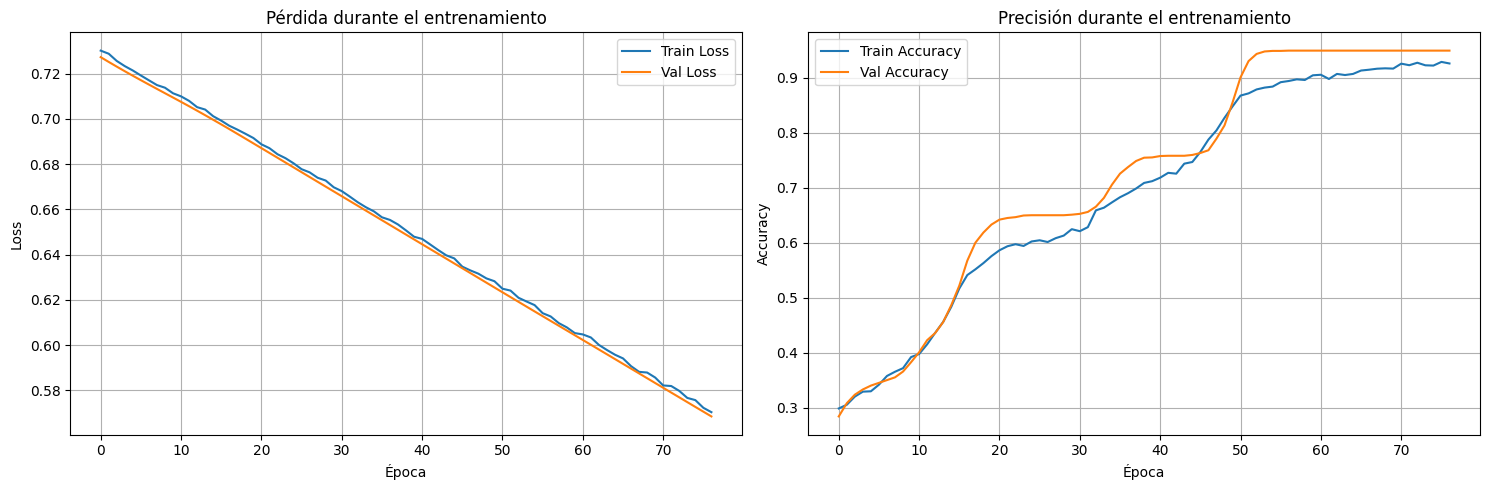

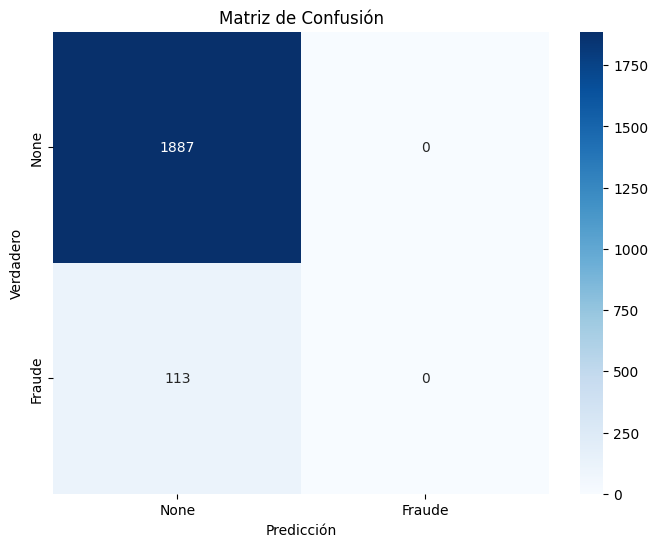

8. Detectando fraudes potenciales...
data predict: Data(x=[10000, 16], edge_index=[2, 1111260], y=[10000])
out predict: tensor([[-0.5409, -0.8727],
        [-0.5446, -0.8677],
        [-0.6304, -0.7601],
        ...,
        [-0.5200, -0.9027],
        [-0.5297, -0.8886],
        [-0.6177, -0.7748]])
data predict_proba: Data(x=[10000, 16], edge_index=[2, 1111260], y=[10000])
out predict_proba: tensor([[-0.5409, -0.8727],
        [-0.5446, -0.8677],
        [-0.6304, -0.7601],
        ...,
        [-0.5200, -0.9027],
        [-0.5297, -0.8886],
        [-0.6177, -0.7748]])
   - Casos sospechosos encontrados: 0

ENTRENAMIENTO COMPLETADO
Modelo guardado en: best_fraud_model.pth
Fraudes potenciales detectados: 0


In [14]:
# ==========================================
# 6. PIPELINE PRINCIPAL
# ==========================================

def main():
    """Pipeline principal de entrenamiento"""
    # 
    # Configurar dispositivo
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Usando dispositivo: {device}")
    # 
    #1. Cargar y procesar datos
    print("1. Cargando datos...")
    processor = FraudGraphDataProcessor()
    raw_data = processor.load_neo4j_data(None)  # Usar datos simulados
    print(f"raw_data: {raw_data}")
    graph_data = processor.create_graph_data(raw_data)
    # 
    print(f"   - Nodos: {graph_data.num_nodes}")
    print(f"   - Bordes: {graph_data.num_edges}")
    print(f"   - Características: {graph_data.num_node_features}")
    # 
    #2. Dividir datos
    print("2. Dividiendo datos...")
    num_nodes = graph_data.num_nodes
    indices = torch.randperm(num_nodes)
    # 
    train_size = int(0.6 * num_nodes)
    val_size = int(0.2 * num_nodes)
    # 
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    # 
    train_mask[indices[:train_size]] = True
    val_mask[indices[train_size:train_size + val_size]] = True
    test_mask[indices[train_size + val_size:]] = True
    # 
   # 3. Crear modelo
    print("3. Creando modelo...")
    model = FraudGNN(
        input_dim=graph_data.num_node_features,
        hidden_dim=HIDDEN_DIM,
        num_classes=len(FRAUD_CLASSES),
        model_type='GCN'  # o 'GAT'
    )
    # 
    print(f"   - Parámetros del modelo: {sum(p.numel() for p in model.parameters())}")
    # 
   # 4. Entrenar
    print("4. Entrenando modelo...")
    trainer = FraudTrainer(model, device)
    graph_data = graph_data.to(device)
    train_mask = train_mask.to(device)
    val_mask = val_mask.to(device)
    test_mask = test_mask.to(device)
 
    history = trainer.train(graph_data, train_mask, val_mask)
    torch.save(model.state_dict(), 'best_fraud_model.pth')
    
   # 5. Evaluar
    print("5. Evaluando modelo...")
    model.load_state_dict(torch.load('best_fraud_model.pth'))
    evaluator = FraudEvaluator(model, device)
    
    test_results = evaluator.evaluate_detailed(graph_data, test_mask)
    
   # 6. Mostrar resultados
    print("6. Resultados:")
    print(f"   - Mejor precisión de validación: {history['best_val_acc']:.4f}")
    print(f"   - ROC AUC: {test_results['roc_auc']:.4f}")
    print("\nReporte de clasificación:")
    print(test_results['classification_report'])
    
   # 7. Visualizar
    print("7. Generando visualizaciones...")
    evaluator.plot_training_history(history)
    evaluator.plot_confusion_matrix(test_results['confusion_matrix'])
    
   # 8. Detectar fraudes potenciales
    print("8. Detectando fraudes potenciales...")
    all_predictions = evaluator.predict(graph_data)
    all_probabilities = evaluator.predict_proba(graph_data)
     
    # Casos con alta probabilidad de fraude pero sin etiqueta
    unlabeled_fraud_candidates = []
    for i in range(len(all_predictions)):
        if graph_data.y[i] == 0:  # Etiquetado como normal
            fraud_prob = all_probabilities[i][1]# + all_probabilities[i][2]
            if fraud_prob > 0.7:  # Alta probabilidad de fraude
                unlabeled_fraud_candidates.append({
                    'node_index': i,
                    'fraud_probability': fraud_prob,
                    'predicted_class': all_predictions[i]
                })
    
    print(f"   - Casos sospechosos encontrados: {len(unlabeled_fraud_candidates)}")
    
    return {
        'model': model,
        'history': history,
        'test_results': test_results,
        'fraud_candidates': unlabeled_fraud_candidates,
        'processor': processor
     }
 
if __name__ == "__main__":
    # Ejecutar pipeline
    torch.manual_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    # 
    results = main()
    # 
    print("\n" + "="*50)
    print("ENTRENAMIENTO COMPLETADO")
    print("="*50)
    print(f"Modelo guardado en: best_fraud_model.pth")
    print(f"Fraudes potenciales detectados: {len(results['fraud_candidates'])}")

## 5.7. Integración con Neo4j real

In [15]:
# ==========================================
# 7. INTEGRACIÓN CON NEO4J REAL
# ==========================================

class Neo4jGraphLoader:
    """Cargador específico para datos reales de Neo4j"""
    
    def __init__(self, uri: str, user: str, password: str):
        from neo4j import GraphDatabase
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
        
    def close(self):
        self.driver.close()
        
    def load_fraud_graph_data(self) -> Dict:
        """Carga datos reales desde tu base de datos Neo4j"""
        
        with self.driver.session() as session:
            # Consulta optimizada para obtener todas las características de nodos
            nodes_query = """
            MATCH (c:CONTADOR)
            OPTIONAL MATCH (c)-[:INVOLUCRADO_EN_FRAUDE]->(ef:EXPEDIENTE_FRAUDE)
            OPTIONAL MATCH (c)-[:MIDE_CONSUMO_DE]->(s:SUMINISTRO)
            OPTIONAL MATCH (c)-[:INSTALADO_EN]->(u:UBICACION)
            OPTIONAL MATCH (c)-[:CONECTADO_A]->(conc:CONCENTRADOR)
            OPTIONAL MATCH (c)-[:GENERA_MEDICION]->(m:MEDICION)
            OPTIONAL MATCH (c)-[:GENERA_EVENTO]->(e:EVENTO)
            OPTIONAL MATCH (c)-[:INSPECCIONADO_EN]->(i:INSPECCION)
            
            WITH c, ef, s, u, conc,
                 count(DISTINCT m) as num_mediciones,
                 avg(m.energia_activa) as consumo_promedio,
                 stdev(m.energia_activa) as consumo_variabilidad,
                 min(m.timestamp_medicion) as primera_medicion,
                 max(m.timestamp_medicion) as ultima_medicion,
                 count(DISTINCT e) as num_eventos,
                 count(DISTINCT i) as num_inspecciones,
                 collect(DISTINCT e.tipo_reporte) as tipos_eventos
                 
            RETURN 
                c.nis_rad as node_id,
                c.numero_contador as numero_contador,
                c.marca_contador as marca,
                c.modelo_contador as modelo,
                c.tipo_aparato as tipo_aparato,
                c.estado_tg as estado_tg,
                c.telegest_activo as telegest_activo,
                c.potencia_maxima as potencia_maxima,
                c.fases_contador as fases,
                c.tension as tension,
                c.version_firmware as version_firmware,
                
                s.estado_contrato as estado_contrato,
                s.potencia_contratada as potencia_contratada,
                s.tension_suministro as tension_suministro,
                s.tipo_punto as tipo_punto,
                s.cnae as cnae,
                s.tarifa_activa as tarifa,
                s.comercializadora_codigo as comercializadora,
                
                u.coordenada_x as coord_x,
                u.coordenada_y as coord_y,
                u.codigo_postal as codigo_postal,
                u.area_ejecucion as area_ejecucion,
                
                conc.estado_comunicacion as estado_comunicacion,
                conc.version_concentrador as version_concentrador,
                
                num_mediciones,
                consumo_promedio,
                consumo_variabilidad,
                primera_medicion,
                ultima_medicion,
                num_eventos,
                num_inspecciones,
                tipos_eventos,
                
                COALESCE(ef.tipo_anomalia, 'NORMAL') as label,
                ef.clasificacion_fraude as tipo_fraude,
                ef.valoracion_total as impacto_economico,
                ef.energia_facturada as energia_facturada,
                ef.fecha_inicio_anomalia as fecha_inicio_fraude,
                ef.fecha_fin_anomalia as fecha_fin_fraude
            """
            
            # Consulta para relaciones del grafo
            edges_query = """
            // Relaciones por proximidad geográfica (< 2km)
            MATCH (c1:CONTADOR)-[:INSTALADO_EN]->(u1:UBICACION)
            MATCH (c2:CONTADOR)-[:INSTALADO_EN]->(u2:UBICACION)
            WHERE c1 <> c2
            AND point.distance(
                point({x: u1.coordenada_x, y: u1.coordenada_y}),
                point({x: u2.coordenada_x, y: u2.coordenada_y})
            ) < 2000
            RETURN c1.nis_rad as source, c2.nis_rad as target, 
                   'PROXIMIDAD_GEOGRAFICA' as relation_type,
                   point.distance(
                       point({x: u1.coordenada_x, y: u1.coordenada_y}),
                       point({x: u2.coordenada_x, y: u2.coordenada_y})
                   ) as atributo_adicional
            
            UNION
            
            // Relaciones por misma comercializadora
            MATCH (c1:CONTADOR)-[:MIDE_CONSUMO_DE]->(s1:SUMINISTRO)
            MATCH (c2:CONTADOR)-[:MIDE_CONSUMO_DE]->(s2:SUMINISTRO)
            WHERE c1 <> c2 
            AND s1.comercializadora_codigo = s2.comercializadora_codigo
            RETURN c1.nis_rad as source, c2.nis_rad as target,
                   'MISMA_COMERCIALIZADORA' as relation_type,
                   s1.comercializadora_codigo as atributo_adicional
            
            UNION
            
            // Relaciones por misma marca y modelo
            MATCH (c1:CONTADOR), (c2:CONTADOR)
            WHERE c1 <> c2
            AND c1.marca_contador = c2.marca_contador
            AND c1.modelo_contador = c2.modelo_contador
            RETURN c1.nis_rad as source, c2.nis_rad as target,
                   'MISMO_MODELO' as relation_type,
                   c1.marca_contador + '_' + c1.modelo_contador as atributo_adicional
            
            UNION
            
            // Relaciones por mismo concentrador
            MATCH (c1:CONTADOR)-[:CONECTADO_A]->(conc:CONCENTRADOR)<-[:CONECTADO_A]-(c2:CONTADOR)
            WHERE c1 <> c2
            RETURN c1.nis_rad as source, c2.nis_rad as target,
                   'MISMO_CONCENTRADOR' as relation_type,
                   conc.concentrador_id as atributo_adicional
            """
            
            # Ejecutar consultas
            nodes_result = session.run(nodes_query)
            edges_result = session.run(edges_query)
            
            # Convertir a DataFrames
            nodes_df = pd.DataFrame([dict(record) for record in nodes_result])
            edges_df = pd.DataFrame([dict(record) for record in edges_result])
            
            print(nodes_df["label"].unique())

            return {
                'nodes': nodes_df,
                'edges': edges_df
            }

## 5.8. Análisis temporal avanzado

In [16]:
# ==========================================
# 8. ANÁLISIS TEMPORAL AVANZADO
# ==========================================

class TemporalFraudAnalyzer:
    """Análisis temporal para detección de fraudes"""
    
    def __init__(self, neo4j_loader: Neo4jGraphLoader):
        self.loader = neo4j_loader
        
    def extract_temporal_features(self, nis_rad: str, days_back: int = 365) -> Dict:
        """Extrae características temporales específicas para un contador"""
        
        with self.loader.driver.session() as session:
            query = """
            MATCH (c:CONTADOR {nis_rad: $nis_rad})-[:GENERA_MEDICION]->(m:MEDICION)
            WHERE m.timestamp_medicion >= datetime() - duration('P' + $days_back + 'D')
            WITH c, m
            ORDER BY m.timestamp_medicion
            
            WITH c, collect(m) as mediciones
            
            // Calcular características temporales
            WITH c, mediciones,
                 [m IN mediciones | m.energia_activa] as consumos,
                 [i IN range(1, size(mediciones)-1) | 
                    mediciones[i].energia_activa - mediciones[i-1].energia_activa] as diferencias
            
            RETURN 
                // Estadísticas básicas
                avg([m IN mediciones | m.energia_activa]) as consumo_promedio,
                stdev([m IN mediciones | m.energia_activa]) as consumo_std,
                min([m IN mediciones | m.energia_activa]) as consumo_min,
                max([m IN mediciones | m.energia_activa]) as consumo_max,
                
                // Detección de cambios bruscos
                size([d IN diferencias WHERE abs(d) > 100]) as cambios_bruscos,
                max([d IN diferencias | abs(d)]) as max_cambio,
                
                // Patrones de resistencia (indicador de manipulación)
                avg([m IN mediciones | m.resistencia_r1]) as resistencia_r1_promedio,
                stdev([m IN mediciones | m.resistencia_r1]) as resistencia_r1_std,
                
                // Consistencia temporal
                size(mediciones) as total_mediciones,
                duration.between(mediciones[0].timestamp_medicion, 
                               mediciones[-1].timestamp_medicion).days as periodo_dias
            """
            
            result = session.run(query, nis_rad=nis_rad, days_back=days_back)
            record = result.single()
            
            if record:
                return dict(record)
            return {}
    
    def detect_consumption_anomalies(self, threshold_std: float = 3.0) -> List[Dict]:
        """Detecta anomalías en patrones de consumo"""
        
        with self.loader.driver.session() as session:
            query = """
            MATCH (c:CONTADOR)-[:GENERA_MEDICION]->(m:MEDICION)
            WHERE m.timestamp_medicion >= datetime() - duration('P90D')
            
            WITH c, 
                 avg(m.energia_activa) as consumo_promedio,
                 stdev(m.energia_activa) as consumo_std,
                 collect(m.energia_activa) as consumos,
                 count(m) as num_mediciones
            
            WHERE consumo_std > 0 AND num_mediciones > 10
            
            // Identificar mediciones anómalas
            WITH c, consumo_promedio, consumo_std, consumos,
                 [consumo IN consumos WHERE 
                    abs(consumo - consumo_promedio) > $threshold_std * consumo_std] as anomalias
            
            WHERE size(anomalias) > 0
            
            RETURN c.nis_rad as nis_rad,
                   consumo_promedio,
                   consumo_std,
                   size(anomalias) as num_anomalias,
                   size(consumos) as total_mediciones,
                   (toFloat(size(anomalias)) / size(consumos)) as porcentaje_anomalias
            
            ORDER BY porcentaje_anomalias DESC
            """
            
            result = session.run(query, threshold_std=threshold_std)
            return [dict(record) for record in result]

# ==========================================
# 9. MODELO GNN HÍBRIDO CON SERIES TEMPORALES
# ==========================================

class HybridTemporalGNN(nn.Module):
    """GNN híbrido que combina características estáticas y temporales"""
    
    def __init__(self, static_dim: int, temporal_dim: int, hidden_dim: int = 64, 
                 num_classes: int = 3, sequence_length: int = 30):
        super(HybridTemporalGNN, self).__init__()
        
        # Encoder para características estáticas (GNN)
        self.static_conv1 = GCNConv(static_dim, hidden_dim)
        self.static_conv2 = GCNConv(hidden_dim, hidden_dim)
        
        # Encoder para series temporales (LSTM/GRU)
        self.temporal_encoder = nn.LSTM(
            temporal_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.2
        )
        
        # Capa de atención para combinar información
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)
        
        # Clasificador final
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, static_x, temporal_x, edge_index, batch=None):
        # Procesar características estáticas con GNN
        static_out = F.relu(self.static_conv1(static_x, edge_index))
        static_out = F.dropout(static_out, training=self.training)
        static_out = self.static_conv2(static_out, edge_index)
        
        # Procesar series temporales con LSTM
        temporal_out, _ = self.temporal_encoder(temporal_x)
        temporal_out = temporal_out[:, -1, :]  # Tomar último estado
        
        # Combinar con atención
        combined_features = torch.cat([
            static_out.unsqueeze(1), 
            temporal_out.unsqueeze(1)
        ], dim=1)
        
        attended_features, _ = self.attention(
            combined_features, combined_features, combined_features
        )
        
        # Concatenar características finales
        final_features = torch.cat([
            attended_features[:, 0, :],  # Estáticas
            attended_features[:, 1, :]   # Temporales
        ], dim=1)
        
        # Clasificar
        output = self.classifier(final_features)
        return F.log_softmax(output, dim=1)

## 5.9. Monitoreo en tiempo real

In [17]:
# ==========================================
# 10. SISTEMA DE MONITOREO EN TIEMPO REAL
# ==========================================

class RealTimeFraudMonitor:
    """Monitor en tiempo real para detección de fraudes"""
    
    def __init__(self, model_path: str, neo4j_loader: Neo4jGraphLoader,
                 threshold_fraud: float = 0.7):
        self.model = torch.load(model_path)
        self.model.eval()
        self.neo4j_loader = neo4j_loader
        self.threshold_fraud = threshold_fraud
        self.alert_history = []
        
    def check_new_measurements(self, hours_back: int = 24) -> List[Dict]:
        """Revisa mediciones recientes en busca de patrones fraudulentos"""
        
        with self.neo4j_loader.driver.session() as session:
            query = """
            MATCH (c:CONTADOR)-[:GENERA_MEDICION]->(m:MEDICION)
            WHERE m.timestamp_medicion >= datetime() - duration('PT' + $hours_back + 'H')
            
            // Agrupar por contador y calcular cambios
            WITH c, collect(m ORDER BY m.timestamp_medicion) as mediciones
            WHERE size(mediciones) >= 2
            
            WITH c, mediciones,
                 mediciones[-1].energia_activa as ultimo_consumo,
                 mediciones[-2].energia_activa as penultimo_consumo,
                 avg([m IN mediciones | m.energia_activa]) as consumo_promedio_reciente
            
            // Detectar caídas bruscas o patrones anómalos
            WHERE ultimo_consumo < (penultimo_consumo * 0.3)  // Caída >70%
               OR ultimo_consumo < (consumo_promedio_reciente * 0.2)  // Muy bajo vs promedio
            
            RETURN c.nis_rad as nis_rad,
                   ultimo_consumo,
                   penultimo_consumo,
                   consumo_promedio_reciente,
                   ((penultimo_consumo - ultimo_consumo) / penultimo_consumo) as porcentaje_caida
            
            ORDER BY porcentaje_caida DESC
            """
            
            result = session.run(query, hours_back=hours_back)
            suspicious_cases = [dict(record) for record in result]
            
            # Evaluar cada caso con el modelo GNN
            alerts = []
            for case in suspicious_cases:
                fraud_probability = self._evaluate_fraud_probability(case['nis_rad'])
                
                if fraud_probability > self.threshold_fraud:
                    alert = {
                        'timestamp': pd.Timestamp.now(),
                        'nis_rad': case['nis_rad'],
                        'fraud_probability': fraud_probability,
                        'trigger': 'CAIDA_BRUSCA_CONSUMO',
                        'details': case,
                        'priority': 'HIGH' if fraud_probability > 0.9 else 'MEDIUM'
                    }
                    alerts.append(alert)
                    self.alert_history.append(alert)
            
            return alerts
    
    def _evaluate_fraud_probability(self, nis_rad: str) -> float:
        """Evalúa probabilidad de fraude para un contador específico"""
        # Aquí implementarías la evaluación con el modelo GNN
        # Por simplicidad, retorna un valor simulado
        return np.random.random()
    
    def generate_daily_report(self) -> Dict:
        """Genera reporte diario de actividad fraudulenta"""
        
        recent_alerts = [alert for alert in self.alert_history 
                        if alert['timestamp'] > pd.Timestamp.now() - pd.Timedelta(days=1)]
        
        return {
            'fecha': pd.Timestamp.now().date(),
            'total_alertas': len(recent_alerts),
            'alertas_alta_prioridad': len([a for a in recent_alerts if a['priority'] == 'HIGH']),
            'alertas_media_prioridad': len([a for a in recent_alerts if a['priority'] == 'MEDIUM']),
            'tipos_triggers': pd.Series([a['trigger'] for a in recent_alerts]).value_counts().to_dict(),
            'contadores_afectados': list(set([a['nis_rad'] for a in recent_alerts])),
            'probabilidad_fraude_promedio': np.mean([a['fraud_probability'] for a in recent_alerts]) if recent_alerts else 0
        }

## 5.10. Uso completo

🚀 INICIANDO PIPELINE DE DETECCIÓN DE FRAUDES GNN
1. Conectando a Neo4j...
2. Cargando datos desde Neo4j...


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownRelationshipTypeWarning} {category: UNRECOGNIZED} {title: The provided relationship type is not in the database.} {description: One of the relationship types in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing relationship type is: INSPECCIONADO_EN)} {position: line: 9, column: 34, offset: 464} for query: "\n            MATCH (c:CONTADOR)\n            OPTIONAL MATCH (c)-[:INVOLUCRADO_EN_FRAUDE]->(ef:EXPEDIENTE_FRAUDE)\n            OPTIONAL MATCH (c)-[:MIDE_CONSUMO_DE]->(s:SUMINISTRO)\n            OPTIONAL MATCH (c)-[:INSTALADO_EN]->(u:UBICACION)\n            OPTIONAL MATCH (c)-[:CONECTADO_A]->(conc:CONCENTRADOR)\n            OPTIONAL MATCH (c)-[:GENERA_MEDICION]->(m:MEDICION)\n            OPTIONAL MATCH (c)-[:GENERA_EVENTO]->(e:EVENTO)\n            OPTIONAL MATC

['NORMAL' 'FRAUDE']
   ✅ Cargados 6 nodos y 4 relaciones
3. Procesando datos para GNN...
raw_data: {'nodes':    node_id numero_contador       marca       modelo     tipo_aparato  \
0  8371757    500000000064  TAPAR00020    146441089  48-CTDOR T5 PLC   
1  7884905    500000000070  TAPAR00020    940276951  48-CTDOR T5 PLC   
2  8231351    500000000070  TAPAR00020    940224163  48-CTDOR T5 PLC   
3  1000008     CNT-1000008  MARCA_TEST  MODELO_TEST             None   
4  1000008     CNT-1000008  MARCA_TEST  MODELO_TEST             None   
5  1001420     CNT-1001420  MARCA_TEST  MODELO_TEST             None   

      estado_tg  telegest_activo  potencia_maxima       fases  tension  ...  \
0     INTEGRADO             True          13856.0   TRIFÁSICO     13.0  ...   
1     INTEGRADO             True           5750.0  MONOFÁSICO     13.0  ...   
2     INTEGRADO             True           5750.0  MONOFÁSICO     13.0  ...   
3  NO_INTEGRADO            False              NaN        None      NaN

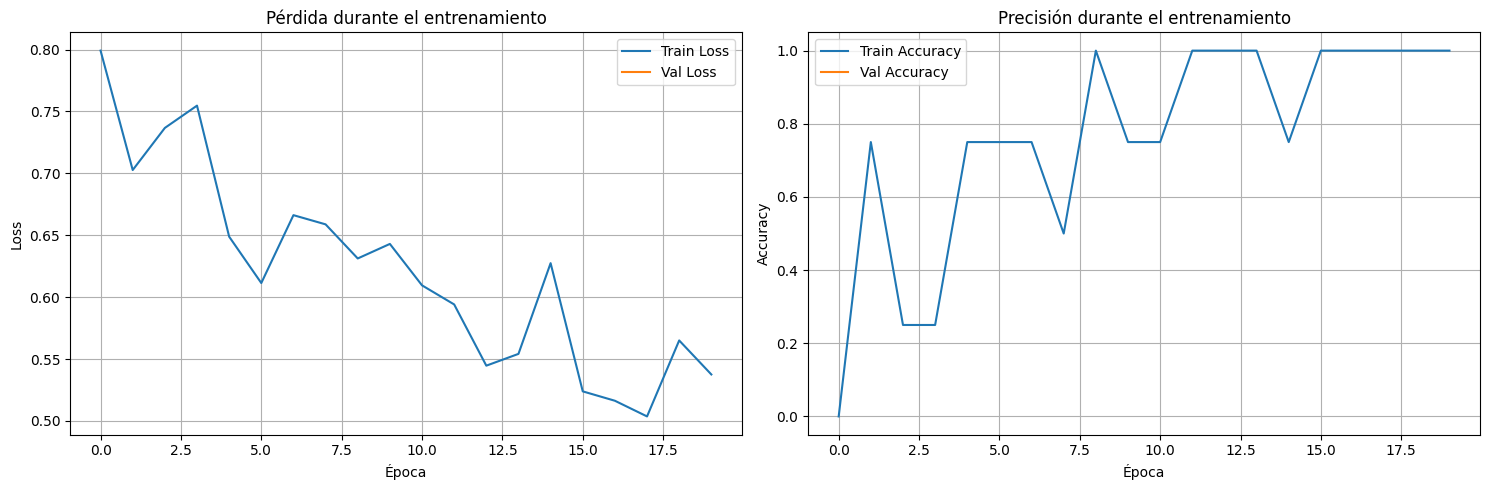

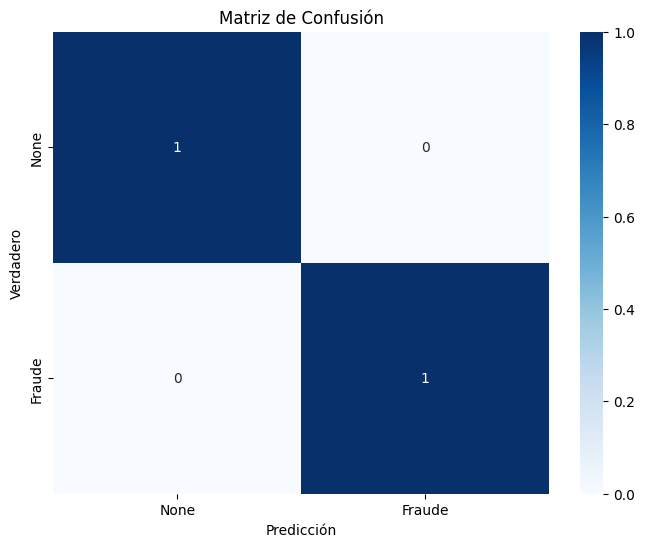

8. Detectando fraudes potenciales...
data predict: Data(x=[6, 16], edge_index=[2, 4], y=[6])
out predict: tensor([[-0.4810, -0.9627],
        [-0.6474, -0.7411],
        [-0.4499, -1.0153],
        [-0.9634, -0.4806],
        [-0.9634, -0.4806],
        [-0.8386, -0.5662]])
data predict_proba: Data(x=[6, 16], edge_index=[2, 4], y=[6])
out predict_proba: tensor([[-0.4810, -0.9627],
        [-0.6474, -0.7411],
        [-0.4499, -1.0153],
        [-0.9634, -0.4806],
        [-0.9634, -0.4806],
        [-0.8386, -0.5662]])
   - Casos sospechosos encontrados: 0


In [18]:
# ==========================================
# 11. EJEMPLO DE USO COMPLETO
# ==========================================

def run_production_pipeline():
    """Pipeline completo para producción"""
    
    print("🚀 INICIANDO PIPELINE DE DETECCIÓN DE FRAUDES GNN")
    print("="*60)
    
    # 1. Conectar a Neo4j
    print("1. Conectando a Neo4j...")
    neo4j_loader = Neo4jGraphLoader(
        uri="bolt://localhost:7687",
        user="neo4j", 
        password="password"
    )
    
    try:
        # 2. Cargar datos reales
        print("2. Cargando datos desde Neo4j...")
        raw_data = neo4j_loader.load_fraud_graph_data()
        print(f"   ✅ Cargados {len(raw_data['nodes'])} nodos y {len(raw_data['edges'])} relaciones")
        
        # 3. Procesar datos para GNN
        print("3. Procesando datos para GNN...")
        processor = FraudGraphDataProcessor()
        print(f"raw_data: {raw_data}")
        graph_data = processor.create_graph_data(raw_data)
        print(f"graph_data: {graph_data}")
        print(f"   ✅ Grafo creado: {graph_data.num_nodes} nodos, {graph_data.num_edges} bordes")
        
        # 4. Entrenar modelo (si no existe)
        model_path = 'production_fraud_model.pth'
        if not os.path.exists(model_path):
            print("4. Entrenando modelo GNN...")
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            
            model = FraudGNN(
                input_dim=graph_data.num_node_features,
                hidden_dim=128,
                num_classes=2,
                model_type='GCN'  # Usar GAT para mejor rendimiento
            )
            
            trainer = FraudTrainer(model, device)
            
            # División de datos
            num_nodes = graph_data.num_nodes
            indices = torch.randperm(num_nodes)
            train_size = int(0.7 * num_nodes)
            val_size = int(0.15 * num_nodes)
            
            train_mask = torch.zeros(num_nodes, dtype=torch.bool)
            val_mask = torch.zeros(num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(num_nodes, dtype=torch.bool)
            
            train_mask[indices[:train_size]] = True
            val_mask[indices[train_size:train_size + val_size]] = True
            test_mask[indices[train_size + val_size:]] = True
            
            # Entrenar
            graph_data = graph_data.to(device)
            history = trainer.train(graph_data, train_mask, val_mask)
            print(f"history: {history}")
            # Guardar modelo
            torch.save(model.state_dict(), model_path)
            print(f"   ✅ Modelo entrenado y guardado en {model_path}")
        else:
            
            print("4. Cargando modelo GNN...")
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = FraudGNN(
                input_dim=graph_data.num_node_features,
                hidden_dim=128,
                num_classes=2,
                model_type='GCN'  # Usar GAT para mejor rendimiento
            )
            model.load_state_dict(torch.load(model_path))
            print(f"   ✅ Modelo cargado desde {model_path}")

              # División de datos
            num_nodes = graph_data.num_nodes
            indices = torch.randperm(num_nodes)
            train_size = int(0.7 * num_nodes)
            val_size = int(0.15 * num_nodes)
            
            train_mask = torch.zeros(num_nodes, dtype=torch.bool)
            val_mask = torch.zeros(num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(num_nodes, dtype=torch.bool)
            
            train_mask[indices[:train_size]] = True
            val_mask[indices[train_size:train_size + val_size]] = True
            test_mask[indices[train_size + val_size:]] = True

         # 5. Evaluar
        print("5. Evaluando modelo...")
        evaluator = FraudEvaluator(model, device)
        
        test_results = evaluator.evaluate_detailed(graph_data, test_mask)
        
        # 6. Mostrar resultados
        print("6. Resultados:")
        print(f"   - Mejor precisión de validación: {history['best_val_acc']:.4f}")
        print(f"   - ROC AUC: {test_results['roc_auc']:.4f}")
        print("\nReporte de clasificación:")
        print(test_results['classification_report'])
        
        # 7. Visualizar
        print("7. Generando visualizaciones...")
        evaluator.plot_training_history(history)
        evaluator.plot_confusion_matrix(test_results['confusion_matrix'])
        
        # 8. Detectar fraudes potenciales
        print("8. Detectando fraudes potenciales...")
        all_predictions = evaluator.predict(graph_data)
        all_probabilities = evaluator.predict_proba(graph_data)
        
        # Casos con alta probabilidad de fraude pero sin etiqueta
        unlabeled_fraud_candidates = []
        for i in range(len(all_predictions)):
            if graph_data.y[i] == 0:  # Etiquetado como normal
                fraud_prob = all_probabilities[i][1] #+ all_probabilities[i][2]
                if fraud_prob > 0.7:  # Alta probabilidad de fraude
                    unlabeled_fraud_candidates.append({
                        'node_index': i,
                        'fraud_probability': fraud_prob,
                        'predicted_class': all_predictions[i]
                    })
        
        print(f"   - Casos sospechosos encontrados: {len(unlabeled_fraud_candidates)}")
        
        return {
            'model': model,
            'history': history,
            'test_results': test_results,
            'fraud_candidates': unlabeled_fraud_candidates,
            'processor': processor
        }

        #5. Configurar monitoreo en tiempo real
        # print("5. Configurando monitoreo en tiempo real...")
        # monitor = RealTimeFraudMonitor(model_path, neo4j_loader)
        # 
        # 6. Ejecutar detección inicial
        # print("6. Ejecutando detección de fraudes...")
        # alerts = monitor.check_new_measurements(hours_back=48)
        # print(f"   ⚠️  {len(alerts)} alertas de fraude detectadas")
        # 
        # for alert in alerts[:5]:  # Mostrar primeras 5
            # print(f"   🚨 {alert['nis_rad']}: {alert['fraud_probability']:.3f} "
                #   f"({alert['priority']}) - {alert['trigger']}")
        # 
        # 7. Generar reporte
        # print("7. Generando reporte diario...")
        # daily_report = monitor.generate_daily_report()
        # print(f"   📊 Total alertas: {daily_report['total_alertas']}")
        # print(f"   🔴 Alta prioridad: {daily_report['alertas_alta_prioridad']}")
        # print(f"   🟡 Media prioridad: {daily_report['alertas_media_prioridad']}")
        # 
        # print("\n✅ PIPELINE COMPLETADO EXITOSAMENTE")
        # return {
            # 'alerts': alerts,
            # 'report': daily_report,
            # 'model_path': model_path,
            # 'monitor': monitor
        # }
        # 
    finally:
        neo4j_loader.close()

# Para ejecutar en producción:
results = run_production_pipeline()